### Libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import seaborn as sns
import io
from contextlib import redirect_stdout
from matplotlib.colors import LinearSegmentedColormap

In [15]:
import warnings
warnings.filterwarnings('ignore')

### Grandger test functions


##### Calculate function


In [2]:
# Función para calcular el test de Granger a lo largo del tiempo
def granger_window_test(data, var_causa, var_efecto, ventana=30, lag = 1 ):
    n = len(data)
    resultados = pd.DataFrame({
        'date': pd.to_datetime(data.index),
        'p_value': [np.nan] * n
    })

    for i in range(ventana, n):
        subset_data = data.iloc[i - ventana + 1:i + 1]
        try:
            test = grangercausalitytests(subset_data[[var_efecto, var_causa]], maxlag=[lag], verbose=False)
            resultados.loc[i, 'p_value'] = test[1][0]['ssr_ftest'][1]
        except Exception as e:
            print(f"Error en el cálculo de Granger para el punto {i}: {str(e)}")
    return resultados

##### Plot function


In [3]:
"""def graficar_granger_test(data, var_causa, var_efecto, ventana=30):
    resultados = data.dropna()

    plt.figure(figsize=(12, 6))
    plt.axhline(y=0.05, color='black', linestyle='--')
    plt.scatter(resultados['date'], resultados['p_value'],
                c=['#CDAD00' if p < 0.05 else '#528B8B' for p in resultados['p_value']], s=1)

    plt.title(f"Causalidad de Granger: {var_causa} -> {var_efecto}")
    plt.suptitle(f"Ventana Movil = {ventana}", y=0.95)
    plt.xlabel("")
    plt.ylabel("Valor p")

    plt.legend(['', 'Influencia Potencial (p < 0.05)'], loc='lower center', bbox_to_anchor=(0.5, -0.15))
    plt.tight_layout()
    return plt"""

def granger_window_plot(data, var_causa, var_efecto, ventana=30):
    resultados = data.dropna()
    
    # Configurar el estilo
    sns.set_style("darkgrid")
    sns.set_palette("deep")
    
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(16, 10))  # Aumentado ligeramente la altura
    
    # Graficar los puntos
    scatter = ax.scatter(resultados['date'], resultados['p_value'],
                         c=['#FFD700' if p < 0.05 else '#4682B4' for p in resultados['p_value']], 
                         s=5, alpha=0.7)
    
    # Añadir línea de umbral
    ax.axhline(y=0.05, color='#FF4500', linestyle='--', linewidth=2, alpha=0.7)
    
    # Configurar títulos y etiquetas
    fig.suptitle(f"Ventana Móvil = {ventana} días", 
                 fontsize=10, fontweight='bold', y=0.90)
    ax.set_title(f"Causalidad de Granger: {var_causa} → {var_efecto}", 
                 fontsize=20, style='italic', pad=30)
    
    ax.set_xlabel(None)
    ax.set_ylabel("Valor p", fontsize=14, labelpad=10)
    
    # Configurar el formato de las fechas en el eje x
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Ajustar los límites del eje y
    ax.set_ylim(-0.05, 1.05)
    
    # Añadir leyenda
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Influencia Potencial (p < 0.05)',
                   markerfacecolor='#FFD700', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Sin Influencia Significativa',
                   markerfacecolor='#4682B4', markersize=10),
        plt.Line2D([0], [0], color='#FF4500', lw=2, linestyle='--', label='Umbral (p = 0.05)')
    ]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              ncol=3, fontsize=12, frameon=True, facecolor='white', edgecolor='gray')
    
    # Ajustar los límites y el diseño
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.2)
    
    # Añadir una cuadrícula más sutil
    ax.grid(True, which='major', linestyle='-', linewidth=0.5, color='#E0E0E0')
    ax.grid(True, which='minor', linestyle=':', linewidth=0.5, color='#F0F0F0')
    
    return fig

##### Calculate and Plot function


In [4]:
def granger_test_temporal_graficas(data, var_causa, var_efecto, ventana=30):
    resultados=granger_window_test(data, var_causa, var_efecto, ventana)
    plot = granger_window_plot(resultados, var_causa, var_efecto, ventana)
    return plot

### Granger index


##### Calculate index


In [5]:
def granger_index(data, max_val=10):
    def impacto(p, max_val):
        return np.where(p <= 0.05, 1 + ((0.05 - p) / 0.05) * (max_val - 1), 1 - (p - 0.05))
    data['index'] = impacto(data['p_value'], max_val)
    return data

##### Calculate 2 variables comparison index


In [16]:
def granger_window_comp_index(data, var1, var2, ventana=30, lag=1, max_val=5):
    n = len(data)
    resultados = pd.DataFrame({
        'date': pd.to_datetime(data.index),
        'p_value_1_2': [np.nan] * n,
        'p_value_2_1': [np.nan] * n,
        'indicador_1_2': [np.nan] * n,
        'indicador_2_1': [np.nan] * n
    })
    
    def impacto(p, max_val):
        return np.where(p <= 0.05, 1 + ((0.05 - p) / 0.05) * (max_val - 1), 1 - (p - 0.05))
    
    for i in range(ventana, n):
        subset_data = data.iloc[i - ventana + 1:i + 1]
        try:
            # Test de var1 causando var2
            test_1_2 = grangercausalitytests(subset_data[[var2, var1]], maxlag=[lag], verbose=False)
            p_value_1_2 = test_1_2[lag][0]['ssr_ftest'][1]
            
            # Test de var2 causando var1
            test_2_1 = grangercausalitytests(subset_data[[var1, var2]], maxlag=[lag], verbose=False)
            p_value_2_1 = test_2_1[lag][0]['ssr_ftest'][1]
            
            resultados.loc[i, 'p_value_1_2'] = p_value_1_2
            resultados.loc[i, 'p_value_2_1'] = p_value_2_1
            
            # Cálculo de los indicadores
            resultados.loc[i, 'indicador_1_2'] = impacto(p_value_1_2, max_val)
            resultados.loc[i, 'indicador_2_1'] = impacto(p_value_2_1, max_val)
        
        except Exception as e:
            print(f"Error en el cálculo de Granger para el punto {i}: {str(e)}")
    
    return resultados

##### Comparison index plot


In [7]:
def granger_comp_index_plot(resultados, var1, var2, color_escala='red'):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
    
    # Crear mapa de colores personalizado
    cmap = LinearSegmentedColormap.from_list("custom", ['darkgray', 'lightgray', color_escala])
    
    # Función para asignar colores
    def asignar_color(valor):
        if valor <= 1:
            return cmap(valor / 2)  # Usar la mitad inferior del mapa de colores para valores <= 1
        else:
            return cmap(0.5 + min(valor - 1, 1) / 2)  # Usar la mitad superior para valores > 1
    
    # Graficar líneas y puntos para var1 causando var2
    colors_1_2 = [asignar_color(v) for v in resultados['indicador_1_2']]
    ax1.scatter(resultados['date'], resultados['indicador_1_2'], c=colors_1_2, s=10, label=f'{var1} -> {var2} (puntos)')
    #for i in range(len(resultados) - 1):
        #ax1.plot(resultados['date'].iloc[i:i+2], resultados['indicador_1_2'].iloc[i:i+2], c=colors_1_2[i])
    
    # Graficar líneas y puntos para var2 causando var1
    colors_2_1 = [asignar_color(v) for v in resultados['indicador_2_1']]
    ax2.scatter(resultados['date'], resultados['indicador_2_1'], c=colors_2_1, s=10, label=f'{var2} -> {var1} (puntos)')
    #for i in range(len(resultados) - 1):
        #ax2.plot(resultados['date'].iloc[i:i+2], resultados['indicador_2_1'].iloc[i:i+2], c=colors_2_1[i])
    
    # Configuración de los gráficos
    for ax in [ax1, ax2]:
        ax.axhline(y=1, color='green', linestyle='--', label='Umbral (p-value = 0.05)')
        ax.set_ylabel('Impacto (> 1 indica posible causalidad)')
        ax.legend()
        ax.set_ylim(0, min(5, max(resultados['indicador_1_2'].max(), resultados['indicador_2_1'].max())))
    
    ax1.set_title(f'Indicador de Causalidad de Granger: {var1} -> {var2}')
    ax2.set_title(f'Indicador de Causalidad de Granger: {var2} -> {var1}')
    ax2.set_xlabel('Fecha')
    
    plt.tight_layout()
    plt.show()

### Oscillator functions


##### Calculate oscillator


##### Oscillator plot


### Log rends function


In [8]:
def calcular_rendimientos_logaritmicos(data, date_column = "date", date_format='%d/%m/%Y'):
    # Verificar si la primera columna es 'date' y si no es el índice
    if data.columns[0] == date_column and data.index.name != date_column:
        # Asegurarse de que la primera columna sea de tipo datetime
        data['date'] = pd.to_datetime(data['date'], format=date_format)
        data.set_index(date_column, inplace=True)
    
    data_rlog = np.log(data / data.shift(1))
    data_rlog = data_rlog.dropna()
    
    return data_rlog

### Data preparation


##### Read and clean raw prices data


In [9]:
data = pd.read_csv("crypto.csv/crypto.csv")
# Seleccionar columnas que contengan prefijo "_close"
data_cl = data.filter(items=['date']).join(data.filter(like='close'))
names = {col: col.replace('USDT_close', '') for col in data_cl.columns}
data_cl = data_cl.rename(columns=names)
data_cl['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M')
data_cl = data_cl.set_index('date')
data_cl.head()

,BTC,ETH,TRX,XRP,SOL,CRV,ZIL,ICX,IOTA,BAND,...,COMP,THETA,ATOM,SNX,VET,QTUM,YFI,BNB,EGLD,LTC
date,,,,,,,,,,,,,,,,,,,,,
2020-09-04 06:00:00,10226.36,382.70,0.04261,0.24742,3.5000,2.814,0.01592,0.4310,0.2741,10.0000,...,189.91,0.38380,4.900,5.153,0.012144,2.369,28221.18,20.3501,17.027,48.21
2020-09-04 07:00:00,10295.59,386.01,0.04258,0.24923,3.5284,2.919,0.01591,0.4312,0.2776,10.0055,...,192.69,0.38484,4.915,5.248,0.012276,2.313,28204.80,20.3055,17.129,48.83
2020-09-04 08:00:00,10421.99,395.65,0.04186,0.25228,3.7211,3.171,0.01635,0.4459,0.2881,10.7356,...,196.03,0.39360,5.228,5.360,0.013178,2.430,29350.47,21.2413,17.277,49.67
2020-09-04 09:00:00,10518.38,399.86,0.04004,0.25640,3.7989,3.282,0.01684,0.4585,0.2949,11.3890,...,197.95,0.41300,5.455,5.538,0.013953,2.582,29306.12,21.5506,17.121,51.45
2020-09-04 10:00:00,10462.26,395.00,0.03861,0.26006,3.6701,3.157,0.01703,0.4539,0.2912,11.4400,...,197.09,0.41584,5.404,5.475,0.014023,2.548,29259.86,21.2299,17.342,51.42


##### Log hourly and daily data


In [10]:
# obtener rendimientos log
data_rlog = calcular_rendimientos_logaritmicos(data_cl)
data_rlog.head()

,BTC,ETH,TRX,XRP,SOL,CRV,ZIL,ICX,IOTA,BAND,...,COMP,THETA,ATOM,SNX,VET,QTUM,YFI,BNB,EGLD,LTC
date,,,,,,,,,,,,,,,,,,,,,
2020-09-04 07:00:00,0.006747,0.008612,-0.000704,0.007289,0.008082,0.036634,-0.000628,0.000464,0.012688,0.000550,...,0.014532,0.002706,0.003057,0.018268,0.010811,-0.023923,-0.000581,-0.002194,0.005973,0.012778
2020-09-04 08:00:00,0.012202,0.024667,-0.017054,0.012163,0.053175,0.082806,0.027280,0.033523,0.037126,0.070430,...,0.017185,0.022508,0.061737,0.021117,0.070903,0.049346,0.039816,0.045056,0.008603,0.017056
2020-09-04 09:00:00,0.009206,0.010585,-0.044452,0.016199,0.020692,0.034406,0.029529,0.027866,0.023329,0.059083,...,0.009747,0.048112,0.042504,0.032669,0.057146,0.060673,-0.001512,0.014456,-0.009070,0.035209
2020-09-04 10:00:00,-0.005350,-0.012229,-0.036368,0.014174,-0.034493,-0.038831,0.011219,-0.010083,-0.012626,0.004468,...,-0.004354,0.006853,-0.009393,-0.011441,0.005004,-0.013256,-0.001580,-0.014993,0.012826,-0.000583
2020-09-04 11:00:00,-0.003839,-0.000937,0.032865,-0.011447,-0.026897,-0.015321,-0.008847,-0.007075,0.006162,-0.033492,...,-0.015905,-0.014143,-0.006684,-0.007333,-0.011620,0.006650,-0.022208,0.007686,0.067392,-0.005851


In [11]:
# obtener datos de cierre diarios y calcular rendimientos logaritmicos
data_d = data_cl.resample('D').last()
data_d_rlog = calcular_rendimientos_logaritmicos(data_d)
data_d_rlog.head()

,BTC,ETH,TRX,XRP,SOL,CRV,ZIL,ICX,IOTA,BAND,...,COMP,THETA,ATOM,SNX,VET,QTUM,YFI,BNB,EGLD,LTC
date,,,,,,,,,,,,,,,,,,,,,
2020-09-05,-0.027126,-0.139758,-0.172907,-0.067081,-0.303817,-0.404939,-0.104758,-0.100962,-0.087861,-0.291091,...,-0.170439,-0.075273,-0.105096,-0.175891,-0.164731,-0.095155,-0.207524,-0.074286,-0.355627,-0.050750
2020-09-06,0.008766,0.051741,0.050255,0.010393,0.171988,0.127728,0.022503,0.053916,0.078821,0.166640,...,0.078887,0.079507,0.051517,0.102561,0.020692,0.032735,0.069764,0.172785,0.081559,0.001880
2020-09-07,0.011366,0.002237,0.033488,0.008800,-0.056647,-0.029600,0.002614,-0.032328,-0.006659,-0.034060,...,0.048832,-0.024595,-0.024437,-0.064821,-0.012462,-0.004967,-0.034709,-0.030688,-0.011209,0.019017
2020-09-08,-0.024078,-0.046899,0.079545,-0.022611,-0.169442,-0.131286,0.014901,-0.054250,-0.027448,-0.090254,...,-0.034651,-0.042435,-0.020191,-0.089599,-0.006743,-0.021389,-0.020522,0.036793,0.059329,-0.028452
2020-09-09,0.009098,0.039119,-0.035000,0.010261,0.377554,0.070333,0.057480,0.031462,0.031308,0.029518,...,0.025637,0.180626,0.071682,0.162260,0.057869,0.033350,0.199854,0.049760,0.072651,0.007346


### Apply granger test


In [17]:
test1 = granger_window_comp_index(data_d_rlog, 'BTC', 'ETH', ventana=30, lag=5, max_val=2)
test1.head(50)

,date,p_value_1_2,p_value_2_1,indicador_1_2,indicador_2_1
0,2020-09-05,NaN,NaN,NaN,NaN
1,2020-09-06,NaN,NaN,NaN,NaN
2,2020-09-07,NaN,NaN,NaN,NaN
3,2020-09-08,NaN,NaN,NaN,NaN
4,2020-09-09,NaN,NaN,NaN,NaN
5,2020-09-10,NaN,NaN,NaN,NaN
6,2020-09-11,NaN,NaN,NaN,NaN
7,2020-09-12,NaN,NaN,NaN,NaN
8,2020-09-13,NaN,NaN,NaN,NaN
9,2020-09-14,NaN,NaN,NaN,NaN


In [18]:
test2 = granger_window_comp_index(data_rlog, 'BTC', 'ETH', ventana=24, lag=1, max_val=5)

### Granger index plot


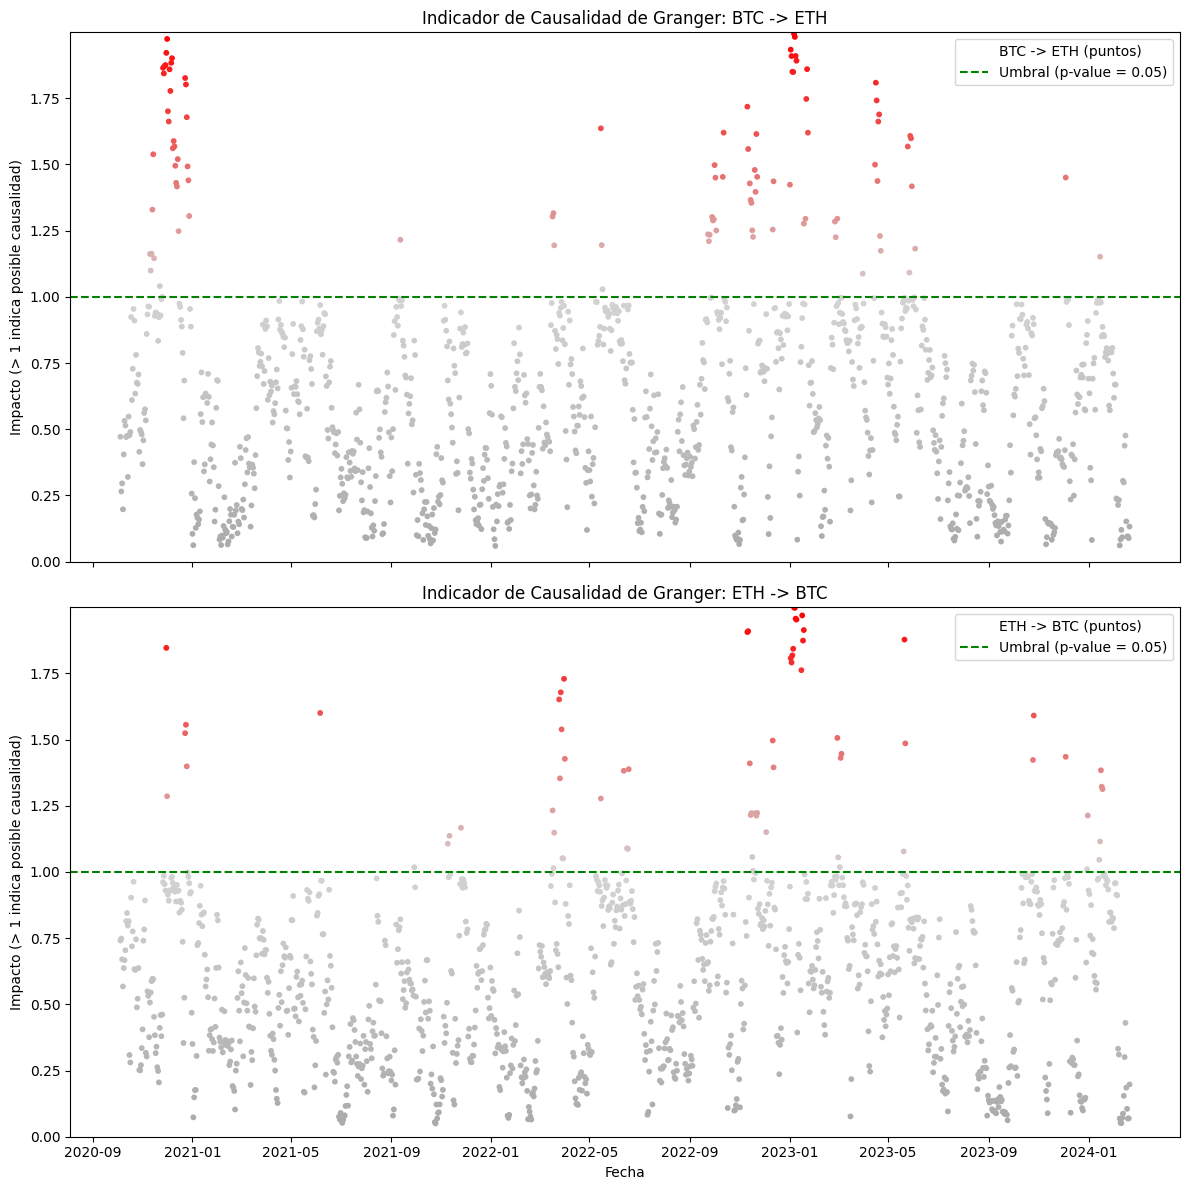

In [30]:
granger_comp_index_plot(test1, 'BTC', 'ETH', color_escala='red')

In [14]:
?grangercausalitytests

Signature: grangercausalitytests(x, maxlag, addconst=True, verbose=None)
Docstring:
Four tests for granger non causality of 2 time series.

All four tests give similar results. `params_ftest` and `ssr_ftest` are
equivalent based on F test which is identical to lmtest:grangertest in R.

Parameters
----------
x : array_like
    The data for testing whether the time series in the second column Granger
    causes the time series in the first column. Missing values are not
    supported.
maxlag : {int, Iterable[int]}
    If an integer, computes the test for all lags up to maxlag. If an
    iterable, computes the tests only for the lags in maxlag.
addconst : bool
    Include a constant in the model.
verbose : bool
    Print results. Deprecated

    .. deprecated: 0.14

       verbose is deprecated and will be removed after 0.15 is released



Returns
-------
dict
    All test results, dictionary keys are the number of lags. For each
    lag the values are a tuple, with the first element a di

C:\Users\Pc\AppData\Local\Temp\ipykernel_97924\4034580295.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Pc\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


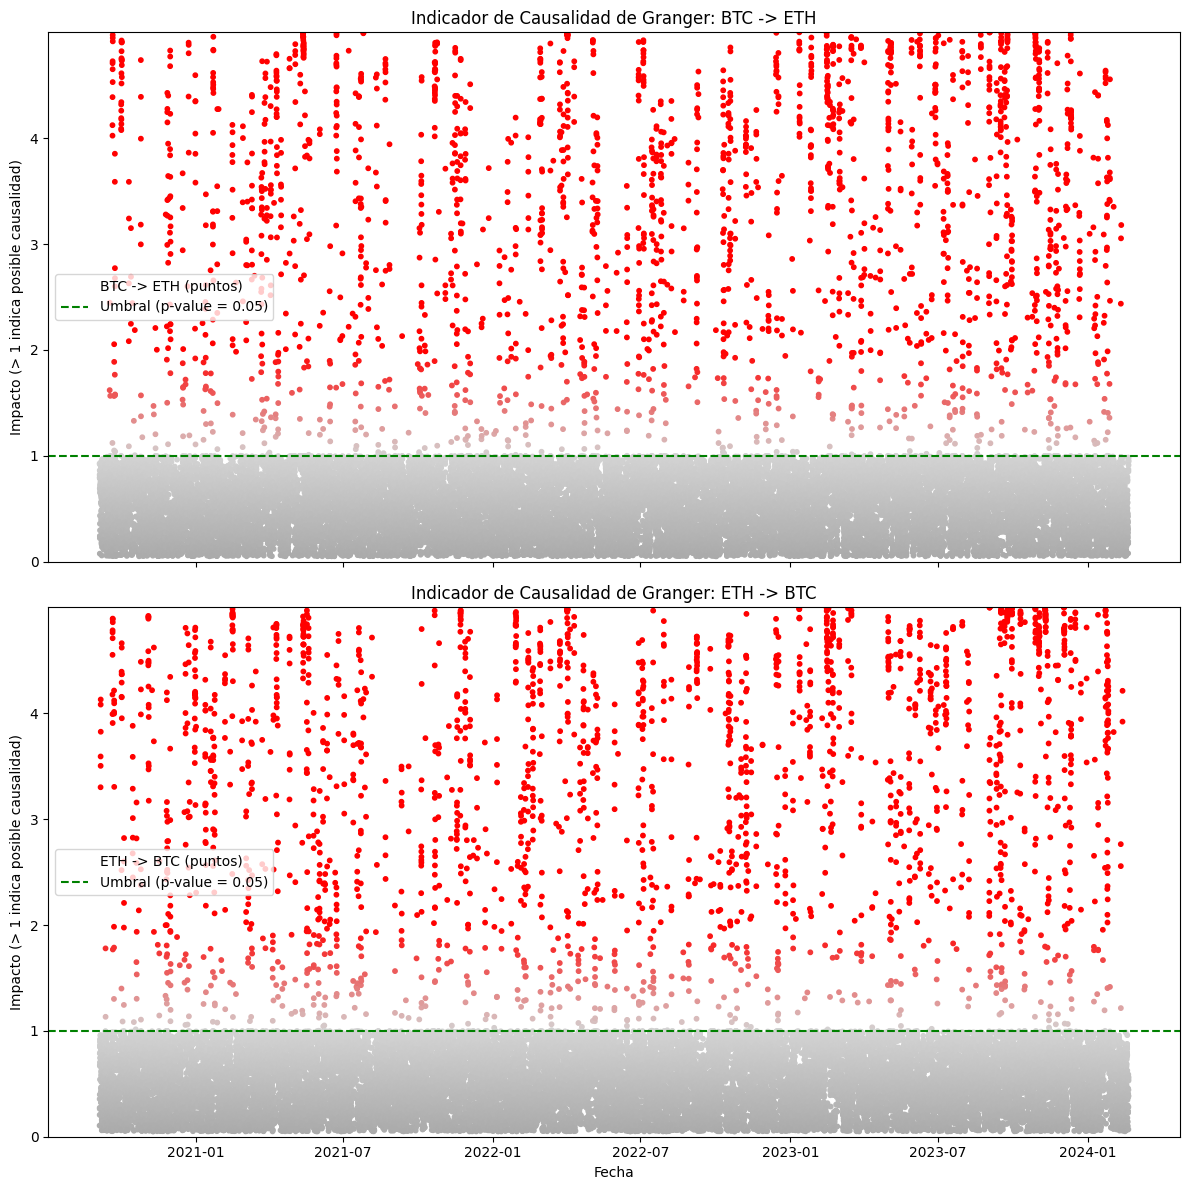

In [13]:
granger_comp_index_plot(test2, 'BTC', 'ETH', color_escala='red')

### Granger causality plot


C:\Users\Pc\AppData\Local\Temp\ipykernel_85924\766339288.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


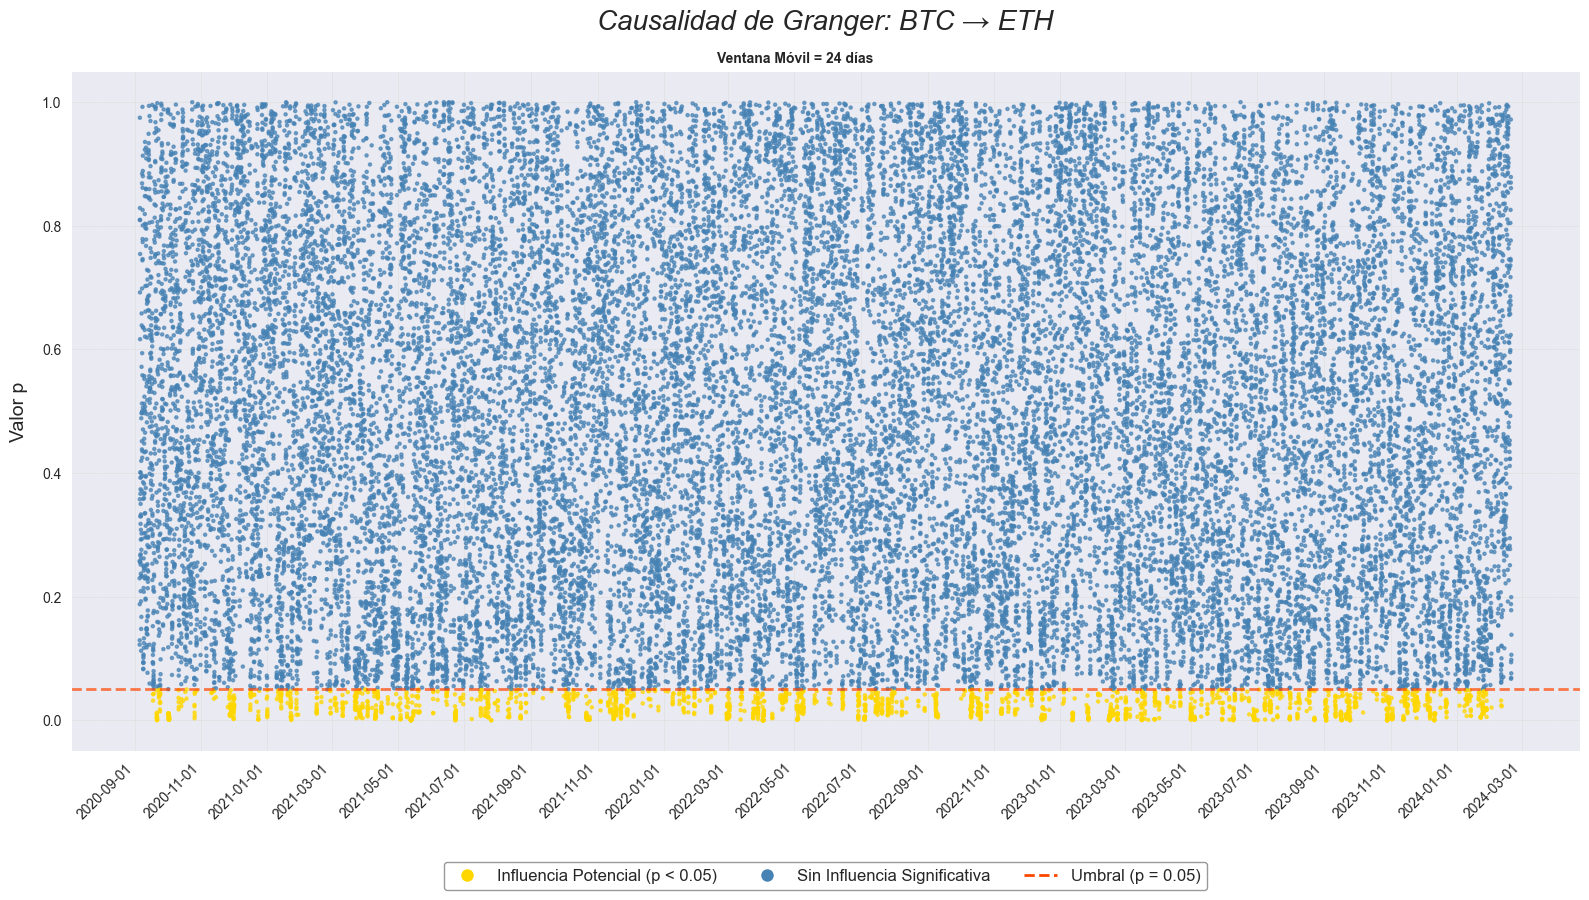

In [11]:
plot = granger_window_plot(resultados_lrends, 'BTC', 'ETH', ventana=24)
plot.show()